# Compute persistence and climatology scores for benchmark

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import seaborn as sns
from src.score import *

In [3]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [4]:
DATADIR = '/data/weather-benchmark/5.625deg/geopotential_500/'
PREDDIR = '/data/weather-benchmark/predictions/'

In [5]:
z500 = xr.open_mfdataset(f'{DATADIR}*').z

/home/rasp/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  """Entry point for launching an IPython kernel.
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [6]:
z500

<xarray.DataArray 'z' (time: 350640, lat: 32, lon: 64)>
dask.array<concatenate, shape=(350640, 32, 64), dtype=float32, chunksize=(8784, 32, 64)>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

## Persistence

In [7]:
z500_validation = load_test_data(DATADIR)

/home/rasp/repositories/weather-benchmark/notebooks/src/score.py:24: FutureWarning: In xarray version 0.14 the default behaviour of `open_mfdataset`
will change. To retain the existing behavior, pass
combine='nested'. To use future default behavior, pass
combine='by_coords'. See
http://xarray.pydata.org/en/stable/combining.html#combining-multi

  ds = xr.open_mfdataset(f'{path}/*.nc')[var]
/home/rasp/miniconda3/lib/python3.7/site-packages/xarray/backends/api.py:934: FutureWarning: The datasets supplied have global dimension coordinates. You may want
to use the new `combine_by_coords` function (or the
`combine='by_coords'` option to `open_mfdataset`) to order the datasets
before concatenation. Alternatively, to continue concatenating based
on the order the datasets are supplied in future, please use the new
`combine_nested` function (or the `combine='nested'` option to
open_mfdataset).
  from_openmfds=True,


In [8]:
z500_validation

<xarray.DataArray 'z' (time: 17520, lat: 32, lon: 64)>
dask.array<getitem, shape=(17520, 32, 64), dtype=float32, chunksize=(8760, 32, 64)>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [9]:
def create_persistence_forecast(da, lead_time_h):
    assert lead_time_h > 0, 'Lead time must be greater than 0'
    da_fc = da.isel(time=slice(0, -lead_time_h))
    return da_fc

In [10]:
fcs = []
lead_times = xr.DataArray(
    np.arange(6, 126, 6), dims=['lead_time'], coords={'lead_time': np.arange(6, 126, 6)})
for lead_time_h in lead_times:
    fcs.append(create_persistence_forecast(z500_validation, int(lead_time_h)))
fc_persistence = xr.concat(fcs, dim=lead_times)

In [11]:
fc_persistence

<xarray.DataArray 'z' (lead_time: 20, time: 17514, lat: 32, lon: 64)>
dask.array<concatenate, shape=(20, 17514, 32, 64), dtype=float32, chunksize=(1, 8760, 32, 64)>
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
    None       (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [14]:
fc_persistence.to_netcdf(f'{PREDDIR}/fc_persistence.nc')

In [15]:
rmses_persistence = evaluate_iterative_forecast(fc_persistence, z500_validation)

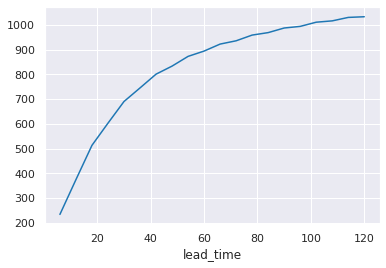

In [16]:
rmses_persistence.plot();

In [17]:
rmses_persistence.sel(lead_time=3*24)

<xarray.DataArray ()>
array(935.90988883)
Coordinates:
    lead_time  int64 72

In [18]:
rmses_persistence.sel(lead_time=5*24)

<xarray.DataArray ()>
array(1033.16034145)
Coordinates:
    lead_time  int64 120

In [30]:
fc_persistence

<xarray.DataArray 'z' (lead_time: 20, time: 17514, lat: 32, lon: 64)>
dask.array<concatenate, shape=(20, 17514, 32, 64), dtype=float32, chunksize=(1, 8760, 32, 64)>
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * lat        (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T17:00:00
    None       (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

## Climatology

In [19]:
def create_climatology_forecast(da_train):
    return da_train.mean('time')

In [20]:
z500_train = z500.sel(time=slice(None, '2016'))

In [21]:
fc = create_climatology_forecast(z500_train)

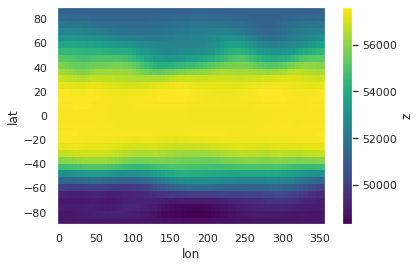

In [22]:
fc.plot();

In [23]:
fc.to_netcdf(f'{PREDDIR}/fc_climatology.nc')

In [24]:
compute_weighted_rmse(fc, z500_validation).values

array(1075.30352815)

In [25]:
def create_weekly_climatology_forecast(da_train, valid_time):
    da_train['week'] = da_train['time.week']
    weekly_averages = da_train.groupby('week').mean('time')
    valid_time['week'] = valid_time['time.week']
    fc_list = []
    for t in valid_time:
        fc_list.append(weekly_averages.sel(week=t.week))
    return xr.concat(fc_list, dim=valid_time)

In [26]:
fc = create_weekly_climatology_forecast(z500_train, z500_validation.time)

In [27]:
fc.to_netcdf(f'{PREDDIR}/fc_weekly_climatology.nc')

In [28]:
fc

<xarray.DataArray 'z' (time: 17520, lat: 32, lon: 64)>
dask.array<concatenate, shape=(17520, 32, 64), dtype=float32, chunksize=(1, 32, 64)>
Coordinates:
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
    week     (time) int64 52 52 52 52 52 52 52 52 52 52 ... 1 1 1 1 1 1 1 1 1 1
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00

In [29]:
compute_weighted_rmse(fc, z500_validation).values

array(815.67783819)

The End